# Big Data - TP #2

El objetivo de este TP es hacer una limpieza y análisis de la EPH. Asimismo, predecir si una persona es o no pobre
utilizando datos distintos al ingreso usando las metodologías vistas en clase.

In [65]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm     

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

## Parte I: Analizando la EPH

In [54]:
# Abrimos el archivo y vemos las primeras cinco filas
eph_indiv = pd.read_excel("../datasets/usu_individual_T123.xlsx")
eph_indiv.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH
0,TQRMNORVWHLMKOCDEOHCH00720228,2023,1,1,5,0,44,N,91,112,...,10.0,9,79700.0,6,6.0,5,NaN,7.0,5,133
1,TQRMNOPSTHKMKPCDEOHCH00781447,2023,1,1,1,1,44,N,91,190,...,6.0,5,180000.0,9,10.0,9,NaN,10.0,9,200
2,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,1,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
3,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,2,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
4,TQRMNOQYTHMNKSCDEOHCH00803178,2023,1,1,1,1,44,N,91,120,...,12.0,12,0.0,12,12.0,12,NaN,12.0,12,0


In [55]:
#Resumen de la base de datos
eph_indiv.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48638 entries, 0 to 48637
Data columns (total 177 columns):
 #    Column      Dtype  
---   ------      -----  
 0    CODUSU      object 
 1    ANO4        int64  
 2    TRIMESTRE   int64  
 3    NRO_HOGAR   int64  
 4    COMPONENTE  int64  
 5    H15         int64  
 6    REGION      int64  
 7    MAS_500     object 
 8    AGLOMERADO  int64  
 9    PONDERA     int64  
 10   CH03        int64  
 11   CH04        int64  
 12   CH05        object 
 13   CH06        int64  
 14   CH07        int64  
 15   CH08        float64
 16   CH09        int64  
 17   CH10        int64  
 18   CH11        int64  
 19   CH12        int64  
 20   CH13        int64  
 21   CH14        float64
 22   CH15        int64  
 23   CH15_COD    float64
 24   CH16        int64  
 25   CH16_COD    float64
 26   NIVEL_ED    int64  
 27   ESTADO      int64  
 28   CAT_OCUP    int64  
 29   CAT_INAC    int64  
 30   IMPUTA      float64
 31   PP02C1      int64  
 32   

In [56]:
#2a) Eliminen todas las observaciones que no corresponden a los aglomerados de CABA o Gran Buenos Aires.

#El siguiente código toma el índice de aquellas observaciones para las que el aglomerado no es ni CABA (32) ni Gran Buenos Aires (33), y elimina las filas que cumplen esa condición. 

eph_indiv= eph_indiv.drop(eph_indiv[(eph_indiv["AGLOMERADO"] != 32) & (eph_indiv["AGLOMERADO"] != 33)].index)

#Para comprobar que funcionó, presentamos los valores que toma la variable "AGLOMERADO":

unique=eph_indiv["AGLOMERADO"].unique() 
print(unique) #Vemos que ahora "Aglomerado" solo toma los valores 32 y 33

[33 32]


In [57]:
#2b) Si hay observaciones con valores que no tienen sentido, descartarlas

#Para identificar aquellas variables que toman valores sin sentido, utilizamos el siguiente comando:
# (Las funciones nanmin y nanmax calculan los valores mínimos y máximos de cada columna sin incluir los valores faltantes, ya que de lo contrario para las variables con valores faltantes "nan" aparece como el valor mínimo y máximo)

for column in eph_indiv.columns:
    try:
        print(column, np.nanmin(eph_indiv[column]), np.nanmax(eph_indiv[column]))
    except:
        print(column)

CODUSU TQRMNOPPQHJNOPCDEIJAH00802435 TQUMNORTQHLMNUCDEIJAH00780261
ANO4 2023 2023
TRIMESTRE 1 1
NRO_HOGAR 1 51
COMPONENTE 1 13
H15 0 2
REGION 1 1
MAS_500 S S
AGLOMERADO 32 33
PONDERA 45 8423
CH03 1 10
CH04 1 2
CH05 1900-01-01 00:00:00 2023-03-02 00:00:00
CH06 -1 99
CH07 1 9
CH08 1.0 12.0
CH09 0 9
CH10 0 9
CH11 0 9
CH12 0 99
CH13 0 9
CH14 0.0 99.0
CH15 0 9
CH15_COD 10.0 449.0
CH16 0 9
CH16_COD 14.0 410.0
NIVEL_ED 1 7
ESTADO 0 4
CAT_OCUP 0 9
CAT_INAC 0 7
IMPUTA 1.0 1.0
PP02C1 0 2
PP02C2 0 2
PP02C3 0 2
PP02C4 0 2
PP02C5 0 2
PP02C6 0 2
PP02C7 0 2
PP02C8 0 2
PP02E 0 5
PP02H 0 2
PP02I 0 2
PP03C 0.0 2.0
PP03D 0.0 6.0
PP3E_TOT 0.0 999.0
PP3F_TOT 0.0 999.0
PP03G 1.0 9.0
PP03H 0.0 9.0
PP03I 1.0 9.0
PP03J 1.0 9.0
INTENSI 1.0 4.0
PP04A 1.0 9.0
PP04B_COD 1.0 9999.0
PP04B1 1.0 2.0
PP04B2 0.0 6.0
PP04B3_MES 0.0 99.0
PP04B3_ANO 0.0 99.0
PP04B3_DIA 0.0 99.0
PP04C 0.0 99.0
PP04C99 0.0 9.0
PP04D_COD 1001.0 99999.0
PP04G 0.0 99.0
PP05B2_MES 0.0 99.0
PP05B2_ANO 0.0 99.0
PP05B2_DIA 0.0 99.0
PP05C_1 0.0 9.0


C:\Users\Ronny\AppData\Local\Temp\ipykernel_5956\857943571.py:8: RuntimeWarning: All-NaN axis encountered
  print(column, np.nanmin(eph_indiv[column]), np.nanmax(eph_indiv[column]))


In [58]:
#Eliminamos observaciones con edades (CH06) menores a 0:
eph_indiv= eph_indiv.drop(eph_indiv[(eph_indiv["CH06"] <0)].index)

#Las variables de ingreso IPCF e ITF no toman valores negativos.

#Reemplazamos los 9, 99, 999, 9999, 99999 por "nan" en aquellas variables en las que dichos codigos corresponden a valores faltantes.

missing_codes= [9, 99, 999, 9999, 99999]

for i in missing_codes:
    for column in eph_indiv.columns:
        if column!="CH06":
            try:
                if np.nanmax(eph_indiv[column])==i:
                    eph_indiv[column]=eph_indiv[column].replace(i, np.nan)
            except:
                print(column, eph_indiv[column].dtype) 

PP09A_ESP object
PP09C_ESP object
PP09A_ESP object
PP09C_ESP object
PP09A_ESP object
PP09C_ESP object
PP09A_ESP object
PP09C_ESP object
PP09A_ESP object
PP09C_ESP object


C:\Users\Ronny\AppData\Local\Temp\ipykernel_5956\2624756829.py:14: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(eph_indiv[column])==i:


In [59]:
#Verificamos que se haya filtrado:

for column in eph_indiv.columns:
    try:
        print(column, np.nanmin(eph_indiv[column]), np.nanmax(eph_indiv[column]))
    except:
        print(column)

CODUSU TQRMNOPPQHJNOPCDEIJAH00802435 TQUMNORTQHLMNUCDEIJAH00780261
ANO4 2023 2023
TRIMESTRE 1 1
NRO_HOGAR 1 51
COMPONENTE 1 13
H15 0 2
REGION 1 1
MAS_500 S S
AGLOMERADO 32 33
PONDERA 45 8423
CH03 1 10
CH04 1 2
CH05 1900-01-01 00:00:00 2022-03-18 00:00:00
CH06 1 99
CH07 1.0 5.0
CH08 1.0 12.0
CH09 1.0 3.0
CH10 0.0 3.0
CH11 0.0 2.0
CH12 0.0 9.0
CH13 0.0 2.0
CH14 0.0 98.0
CH15 1.0 5.0
CH15_COD 10.0 449.0
CH16 0.0 6.0
CH16_COD 14.0 410.0
NIVEL_ED 1 7
ESTADO 0 4
CAT_OCUP 0.0 4.0
CAT_INAC 0 7
IMPUTA 1.0 1.0
PP02C1 0 2
PP02C2 0 2
PP02C3 0 2
PP02C4 0 2
PP02C5 0 2
PP02C6 0 2
PP02C7 0 2
PP02C8 0 2
PP02E 0 5
PP02H 0 2
PP02I 0 2
PP03C 0.0 2.0
PP03D 0.0 6.0
PP3E_TOT 0.0 168.0
PP3F_TOT 0.0 56.0
PP03G 1.0 2.0
PP03H 0.0 3.0
PP03I 1.0 2.0
PP03J 1.0 2.0
INTENSI 1.0 4.0
PP04A 1.0 3.0
PP04B_COD 1.0 9900.0
PP04B1 1.0 2.0
PP04B2 0.0 6.0
PP04B3_MES 0.0 11.0
PP04B3_ANO 0.0 40.0
PP04B3_DIA 0.0 30.0
PP04C 0.0 12.0
PP04C99 0.0 3.0
PP04D_COD 1001.0 99998.0
PP04G 0.0 10.0
PP05B2_MES 0.0 6.0
PP05B2_ANO 0.0 10.0
PP05

C:\Users\Ronny\AppData\Local\Temp\ipykernel_5956\2269627186.py:5: RuntimeWarning: All-NaN axis encountered
  print(column, np.nanmin(eph_indiv[column]), np.nanmax(eph_indiv[column]))


Mujer    51.961432
Varón    48.038568
Name: gender, dtype: float64


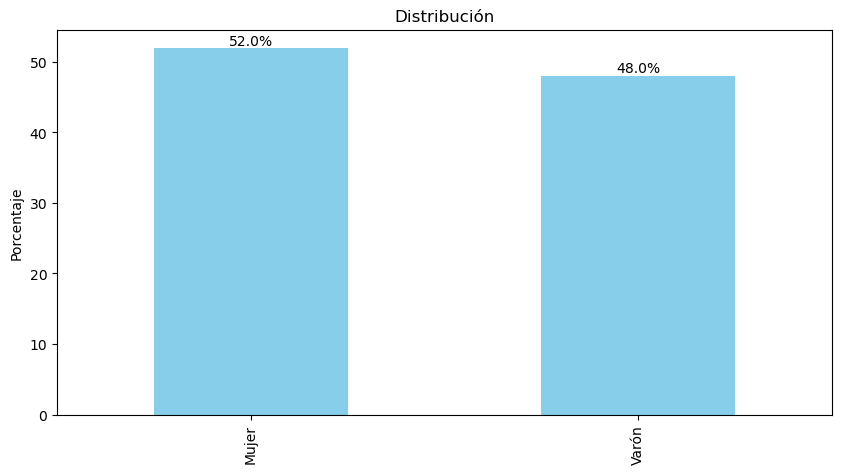

In [60]:
#2c) Gráfico de barras mostrando la composición por sexo
eph_indiv['gender'] = eph_indiv['CH04'].map({1: 'Varón', 2: 'Mujer'})
gender_counts = eph_indiv['gender'].value_counts(normalize=True) * 100
print(gender_counts) # Para conocer los porcentajes

# Gráfico de barras
barplot = plt.figure(figsize = (10, 5))
ax = gender_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución')
plt.ylabel('Porcentaje')

# Add percentage labels on top of the bars
for i, v in enumerate(gender_counts):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.show()

              CH04      CH07      CH08  NIVEL_ED    ESTADO  CAT_INAC      IPCF
CH04      1.000000 -0.000175 -0.019780  0.050053  0.111855  0.079618 -0.024220
CH07     -0.000175  1.000000  0.068998 -0.082108  0.417708  0.409669 -0.042780
CH08     -0.019780  0.068998  1.000000 -0.000644  0.019759  0.088826 -0.069497
NIVEL_ED  0.050053 -0.082108 -0.000644  1.000000 -0.205541 -0.045002  0.151222
ESTADO    0.111855  0.417708  0.019759 -0.205541  1.000000  0.822162 -0.107492
CAT_INAC  0.079618  0.409669  0.088826 -0.045002  0.822162  1.000000 -0.110865
IPCF     -0.024220 -0.042780 -0.069497  0.151222 -0.107492 -0.110865  1.000000


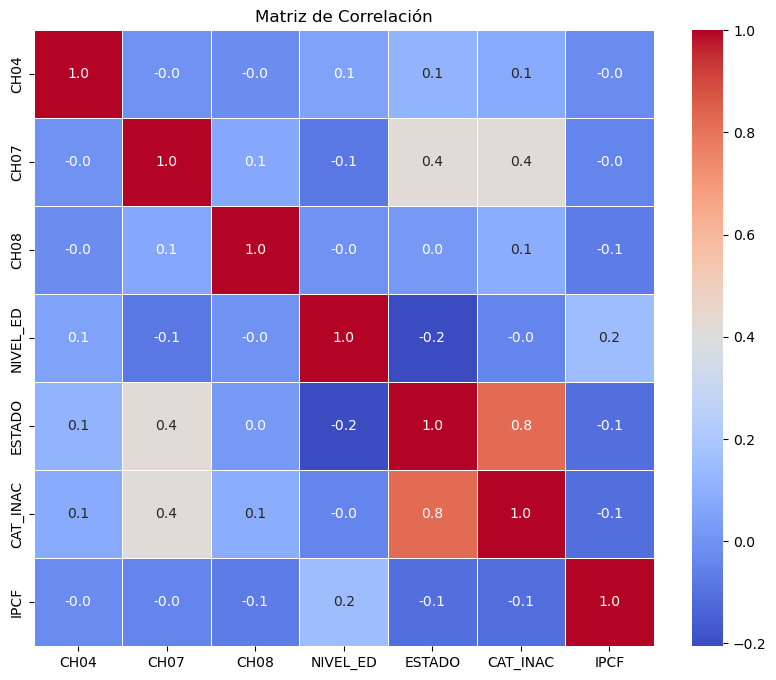

In [61]:
#2d) Matriz de correlación con las siguientes variables
covars = eph_indiv[['CH04', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF']] # Variables
corr_matrix = covars.corr()
print(corr_matrix) #Matriz de correlación

# Ahora hacemos un gráfico usando la librería 'seaborn'
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap= "coolwarm", fmt=".1f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

In [62]:
#2e) Calcular a los desocupados, inactivos y la media del Ingreso Per Capita Familiar segun estado (ocupado, desocupado, inactivo)

ocupados = (eph_indiv["ESTADO"] == 1).sum()
print("Número de ocupados en la muestra:" + str(ocupados))
desocupados=(eph_indiv["ESTADO"] == 2).sum()
print("Número de desocupados en la muestra:" + str(desocupados))
inactivos = (eph_indiv["ESTADO"] == 3).sum()
print("Número de inactivos en la muestra:" + str(inactivos))


#Para calcular el ingreso per capita para cada grupo, usamos la función loc, ya que necesitamos seleccionar una columna en particular para aquellas filas que cumplen cierta condición.

ingreso_ipcf_ocupados= eph_indiv.loc[eph_indiv["ESTADO"] == 1, "IPCF"].mean()
print("La media del IPCF para los ocupados es:" + str(ingreso_ipcf_ocupados))

ingreso_ipcf_desocupados= eph_indiv.loc[eph_indiv["ESTADO"] == 2, "IPCF"].mean()
print("La media del IPCF para los desocupados es:" + str(ingreso_ipcf_desocupados))

ingreso_ipcf_inactivos= eph_indiv.loc[eph_indiv["ESTADO"] == 3, "IPCF"].mean()
print("La media del IPCF para los inactivos es:" + str(ingreso_ipcf_inactivos))

Número de ocupados en la muestra:3523
Número de desocupados en la muestra:286
Número de inactivos en la muestra:2837
La media del IPCF para los ocupados es:59579.4429151292
La media del IPCF para los desocupados es:25536.02220279721
La media del IPCF para los inactivos es:40067.99605216777


In [63]:
#2f) Juntamos con el archivo tabla adulto equiv.xlsx

adulto = pd.read_excel("../datasets/tabla_adulto_equiv.xlsx")

In [67]:
#Acomodamos la base:

adulto=adulto[4:27]
adulto["Edad"]=adulto["Tabla de equivalencias de necesidades energéticas. Unidades de adulto equivalente, según sexo y edad"]
adulto["2"]=adulto["Unnamed: 1"]
adulto["1"]=adulto["Unnamed: 2"]
adulto= adulto[["Edad", "2", "1"]]

adulto["Edad"]=adulto["Edad"].str.replace("años", "").str.replace("año", "").str.replace(" ", "").str.replace("a", "")
adulto = adulto.set_index("Edad")

KeyError: 'Tabla de equivalencias de necesidades energéticas. Unidades de adulto equivalente, según sexo y edad'

In [17]:
#Chequeamos los valores que toman las variables de genero (CH04) y edad (CH06) en la base eph_indiv:

print(eph_indiv["CH04"].unique())
print(eph_indiv["CH06"].unique())

[2 1]
[65 70 36 28  9 59 55 18 44 45 10  3 62 67 53 51 29 39 24  6 34  4  1 52
 50 31 23 14  5 61 25 21 46 16 22 42 38 19 12 75 17 27 49 77 66  2 87 37
 48 78 74 90 13 71  7 41 47 33 63 72 35 86 92 82 58 69 30 57 85 80 79 68
 83 54 26 11 40 60 32 73 64  8 56 43 99 15 81 20 89 84 76 97 91 88 93 94
 95 96]


In [52]:
def equivalencia(edad, genero):
    if edad <18: #No hay observaciones con edades menor a 1, asi que la aquivalencia para las personas de menos de 1 año de edad no es un problema en este caso
        equiv= adulto.at[str(edad),str(genero)]
    if edad>=18 and edad <30:
        equiv= adulto.at["1829", str(genero)]
    if edad>=30 and edad <46:
        equiv= adulto.at["3045", str(genero)]   
    if edad>=46 and edad <61:
        equiv= adulto.at["4660", str(genero)]   
    if edad>=61 and edad <76: #No queda claro en la tabla, pero asumimos que las personas de 75 están incluidas en esta categoría
        equiv= adulto.at["6175", str(genero)]    
    if edad>=76:
        equiv= adulto.at["másde75", str(genero)] 
    return(equiv)  

eph_indiv["adulto_equiv"]= eph_indiv.apply(lambda x: equivalencia(x.CH06, x.CH04), axis=1)

In [53]:
#Visualizamos los resultados:
display(eph_indiv[["CH04", "CH06", "adulto_equiv"]])

TypeError: 'RocCurveDisplay' object is not callable

In [20]:
suma=eph_indiv.groupby(by=["CODUSU", "NRO_HOGAR"]).agg({"adulto_equiv":"sum"})

In [21]:
display(suma)

,,adulto_equiv
CODUSU,NRO_HOGAR,
TQRMNOPPQHJNOPCDEIJAH00802435,1,3.54
TQRMNOPPQHKMQRCDEIJAH00780809,1,4.48
TQRMNOPPQHLNKTCDEIIAD00780107,1,2.14
TQRMNOPPQHLOKTCDEIJAH00719666,1,1.00
TQRMNOPPQHMKLSCDEIIAD00801791,1,1.41
...,...,...
TQTMNORTQHLMNUCDEIJAH00793701,1,3.58
TQTMNORTYHJOPMCDEIJAH00794674,1,1.78
TQUMNOQQUHKNRUCDEIJAH00780938,1,3.07


In [22]:
suma["ad_equiv_hogar"]=suma["adulto_equiv"]
suma = suma.drop('adulto_equiv', axis=1)
display(suma)

,,ad_equiv_hogar
CODUSU,NRO_HOGAR,
TQRMNOPPQHJNOPCDEIJAH00802435,1,3.54
TQRMNOPPQHKMQRCDEIJAH00780809,1,4.48
TQRMNOPPQHLNKTCDEIIAD00780107,1,2.14
TQRMNOPPQHLOKTCDEIJAH00719666,1,1.00
TQRMNOPPQHMKLSCDEIIAD00801791,1,1.41
...,...,...
TQTMNORTQHLMNUCDEIJAH00793701,1,3.58
TQTMNORTYHJOPMCDEIJAH00794674,1,1.78
TQUMNOQQUHKNRUCDEIJAH00780938,1,3.07


In [23]:
eph_merge=eph_indiv.merge(suma, on=['CODUSU','NRO_HOGAR'], how='left')

In [24]:
eph_merge

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH,gender,adulto_equiv,ad_equiv_hogar
0,TQRMNORUYHLMSMCDEIJAH00719364,2023,1,1,1,1,1,S,33,1545,...,5,NaN,5,5.0,NaN,6,2540,Mujer,0.67,1.50
1,TQRMNORUYHLMSMCDEIJAH00719364,2023,1,1,2,1,1,S,33,1545,...,5,NaN,5,5.0,NaN,6,2540,Varón,0.83,1.50
2,TQRMNOSRQHJNSOCDEIJAH00802640,2023,1,1,1,1,1,S,33,8423,...,1,NaN,1,1.0,NaN,1,14082,Varón,1.00,2.45
3,TQRMNOSRQHJNSOCDEIJAH00802640,2023,1,1,2,1,1,S,33,8423,...,1,NaN,1,1.0,NaN,1,14082,Mujer,0.76,2.45
4,TQRMNOSRQHJNSOCDEIJAH00802640,2023,1,1,3,0,1,S,33,8423,...,1,NaN,1,1.0,NaN,1,14082,Mujer,0.69,2.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7566,TQRMNOQPTHKKRRCDEIJAH00780327,2023,1,1,1,1,1,S,33,1300,...,10,NaN,10,10.0,NaN,10,1516,Mujer,0.63,0.63
7567,TQRMNOPTXHKORSCDEIJAH00780269,2023,1,1,1,1,1,S,33,1193,...,12,NaN,12,12.0,NaN,12,0,Mujer,0.77,2.83
7568,TQRMNOPTXHKORSCDEIJAH00780269,2023,1,1,2,1,1,S,33,1193,...,12,NaN,12,12.0,NaN,12,0,Varón,1.04,2.83
7569,TQRMNOPTXHKORSCDEIJAH00780269,2023,1,1,3,1,1,S,33,1193,...,12,NaN,12,12.0,NaN,12,0,Varón,1.02,2.83


In [25]:
eph_indiv=eph_merge

In [26]:
#3) Chequeamos valores faltantes en la columna "ITF":

missing_values_ITF = eph_indiv['ITF'].isna().sum()
print(missing_values_ITF) #No hay valores faltantes

#Chequeamos observaciones para las que el ITF toma valor 0:

print((eph_indiv['ITF']==0).sum()) #3390 observaciones

0
3390


In [49]:
#Guarden como una base distinta llamada respondieron las observaciones donde respondieron la pregunta sobre su ITF. 
#Las observaciones con ITF = 0 guardenlas en una base bajo el nombre norespondieron.

respondieron=eph_indiv[eph_indiv["ITF"]>0]
norespondieron=eph_indiv[eph_indiv["ITF"]==0]

In [50]:
#Comprobamos que en la base "respondieron" todos los valores de ITF sean mayores a 0, y que en la base "norespondieron" ITF tome solo valor 0.
print(respondieron["ITF"].describe())
print(norespondieron["ITF"].describe())

count    4.181000e+03
mean     2.503417e+05
std      4.194312e+05
min      2.500000e+03
25%      1.150000e+05
50%      1.800000e+05
75%      3.000000e+05
max      1.099000e+07
Name: ITF, dtype: float64
count    3390.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: ITF, dtype: float64


In [51]:
#4)la Canasta Basica Total para un adulto equivalente en el GBA en el primer trimestre de 2023 es aproximadamente $57.371,05.
#Agreguen a la base respondieron una columna llamada ingreso necesario, que sea el producto de este valor por ad equiv hogar.

respondieron["ingreso_necesario"]= 57371.05*respondieron["ad_equiv_hogar"]
display(respondieron[["CODUSU", "NRO_HOGAR", "ingreso_necesario", "ad_equiv_hogar"]])

C:\Users\Ronny\AppData\Local\Temp\ipykernel_5956\1867158894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["ingreso_necesario"]= 57371.05*respondieron["ad_equiv_hogar"]


TypeError: 'RocCurveDisplay' object is not callable

In [30]:
#5) Agreguen a respondieron una columna llamada pobre que tome valor 1 si el ITF es menor al ingreso necesario que necesita esa familia, y 0 en caso contrario. 

respondieron["pobre"] = (respondieron["ITF"]< respondieron["ingreso_necesario"]).astype(int)

#"astype(int) convierte los valores "True" y "False" en 1 y 0

display (respondieron[["ITF", "ingreso_necesario", "pobre"]])


C:\Users\Ronny\AppData\Local\Temp\ipykernel_5956\3252795619.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["pobre"] = (respondieron["ITF"]< respondieron["ingreso_necesario"]).astype(int)


,ITF,ingreso_necesario,pobre
0,135000,86056.5750,0
1,135000,86056.5750,0
2,70000,140559.0725,1
3,70000,140559.0725,1
4,70000,140559.0725,1
...,...,...,...
7562,155000,219157.4110,1
7563,480000,141132.7830,0
7564,480000,141132.7830,0
7565,480000,141132.7830,0


In [47]:
#¿Cuantos pobres identificaron?

pobres = (respondieron["pobre"] == 1).sum()
print("Número de pobres:" + str(pobres)) 

#Identificamos 1555 pobres, de un total de 4181 individuos que componen la base, es decir, 37,19% de pobres

Número de pobres:1555


## Parte II: Clasificación

El objetivo de esta parte del trabajo es intentar predecir la condición de pobreza utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder
cuánto ganan.

### Inciso 1: Preparación de la base de datos

In [48]:
# Todas las variables que borraremos: 6 primeras filas son categorías de ingresos
dropvars = ["P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR", "PONDIIO", # Ocupación principal
            "TOT_P12", #Otra ocupaciones
            "P47T", "DECINDR", "IDECINDR", "RDECINDR", "GDECINDR", "PDECINDR", "ADECINDR", "PONDII", #Individual
            "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM", "V21_M", "T_VI", #No laborales
            "ITF", "DECIFR", "IDECIFR", "RDECIFR", "GDECIFR", "PDECIFR", "ADECIFR", # Total Familiar
            "IPCF", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR", "PDECCFR", "ADECCFR", "PONDIH" #Per cap familiar
            , adulto_equiv, ad_equiv_hogar, ingreso_necesario] # Otras variables
            


respondieron_new = respondieron.drop(columns=dropvars)

# Verificamos:
variable_names = respondieron_new.columns.tolist()
print("Nombre de las variables:")
for var_name in variable_names:
    print(var_name) #Todo OK!

NameError: name 'adulto_equiv' is not defined

### Inciso 2: Muestra de entrenamiento y test

<span style="color:red">ADVERTENCIA</span>: Esta parta también está "mal". Lo que hice fue definiar la variable "pobre" de la manera más simple posible. En la parte I se debería definir de mejor manera esta variable (con metodología de adultos equivalentes).

In [33]:
# Variable dependiente: pobre
print("Número de pobres:\n", respondieron_new.pobre.value_counts())
print("Porcentaje de pobres:\n", respondieron_new.pobre.value_counts(normalize=True) * 100)

Número de pobres:
 0    2626
1    1555
Name: pobre, dtype: int64
Porcentaje de pobres:
 0    62.807941
1    37.192059
Name: pobre, dtype: float64


In [34]:
# Preparativos antes de dividir la muestra

# 1) Borramos los missings
respondieron_new_nm = respondieron_new.dropna(axis=1, how='all') 

# 2) Seleccionamos todas las variables excepto "pobre"
X = respondieron_new_nm.drop(columns=["pobre"]) 

# 3) Recodificamos MAS_500 (lugar con más de 500,000 habitantes) a 0 si es 'N' o 1 si es 'S'
X["MAS_500"].replace({"N": 0, "S": 1}, inplace=True)

# 4) Agregamos la constante
X["const"] = 1

# 5) Cambiamos al objeto de nombre
y = respondieron_new_nm["pobre"] 
y=y.to_numpy()

Hasta esta parte, seguimos todas las indicaciones de la consigna. Definimos la matriz X de predictores como todas las variables excepto la variable predicha (pobreza). Sin embargo, algunas variables de la EPH son irrelevantes para la predicción de la pobreza. Por ejemplo, el número del hogar, el año, trimestre, entre otras. Volveremos a modificar las variables de la matriz X antes de partir la muestra.

In [35]:
# 4) Borramos las variables que no son numéricas
X = X.select_dtypes(include=["number"])

# ... Y otras que son numéricas, pero no aportan mucho en este caso
X = X.drop(columns=["ANO4", "TRIMESTRE", "NRO_HOGAR", "COMPONENTE", "REGION"]) 

Algunas variabels tienen al menos un missing value. Esto nos limita para usar la regresión logístico y otros métodos de clasificación. La solución que planteamos es *imputar los datos usando el método del promedio*. Luego de esto, ya podremos partir la muestra.

In [36]:

# Hay variables que tienen al menos un missing value, lo que no permitirá correr la regresión logística
# Solución: Imputar la data usando la media
#imputer = SimpleImputer(strategy='mean')
#X = imputer.fit_transform(X)

# Reemplazamos valores que podrían causar conflicto en la estimación de los modelos
X = X.replace(np.nan, 0) #Valores missing


In [37]:
# Ahora si podemos partir la muestra:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=201)

# Verificamos el número de observaciones para cada objeto
print("Muestra de entrenamiento. Obs:", "X=", len(X_train), "Y=", len(y_train))
print("Muestra de prueba. Obs:", "X=", len(X_test), "Y=", len(y_test))

Muestra de entrenamiento. Obs: X= 2926 Y= 2926
Muestra de prueba. Obs: X= 1255 Y= 1255


#### Modelo Logit

In [38]:
# Estimamos el modelo
# Puse más iteraciones porque no daba...
log_reg = LogisticRegression().fit(X_train, y_train)
y_test_pred_score = log_reg.predict_proba(X_test)[:,1]
y_test_pred = log_reg.predict(X_test)

c:\Users\Ronny\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
# Matriz de confusión y accuracy
print('Matriz de confusión:\n', confusion_matrix(y_test, y_test_pred))
print('Accuracy Score:\n', accuracy_score(y_test, y_test_pred))

Matriz de confusión:
 [[537 269]
 [115 334]]
Accuracy Score:
 0.6940239043824701


AUC: 0.705064190066704621
[2 1 0]
[0.        0.3337469 1.       ]
[0.         0.74387528 1.        ]


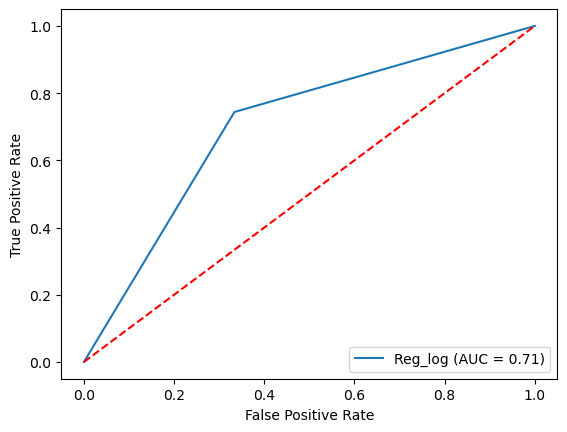

In [40]:
# Curva ROC y AUC score
auc = roc_auc_score(y_test, y_test_pred)
print('AUC: %.18f' % auc) 

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
np.set_printoptions(suppress = True)
print(thresholds)
print(fpr)
print(tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Reg_log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show()

#### KNN

In [41]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [42]:
# Predecimos con el modelo KNN sobre las X test
y_pred_knn = knn.predict(X_test)

c:\Users\Ronny\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [43]:
matriz_confusion_knn = confusion_matrix(y_test, y_pred_knn)
ac_knn = accuracy_score(y_test, y_pred_knn) 

print('Matriz de confusión:\n', matriz_confusion_knn)
print('Accuracy Score: %.3f' %ac_knn)

Matriz de confusión:
 [[655 151]
 [124 325]]
Accuracy Score: 0.781



 AUC KNN: 0.77 



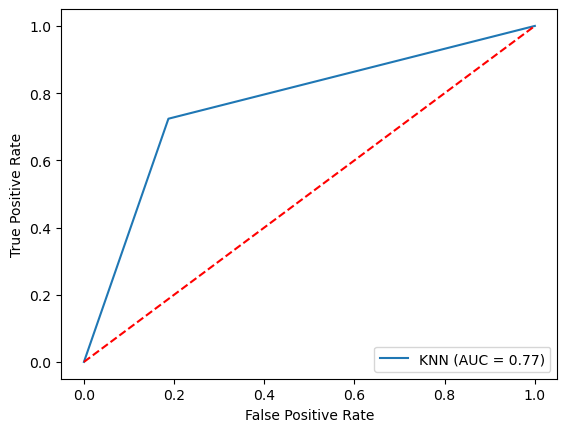

In [44]:
# AUC y KNN
auc_knn = roc_auc_score(y_test, y_pred_knn)
print('\n','AUC KNN:', '%.2f' % auc_knn,'\n')

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)

display = RocCurveDisplay(fpr=fpr_knn, tpr=tpr_knn, roc_auc=auc_knn, estimator_name='KNN')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#### Análisis de discriminante lineal

In [45]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda = lda.fit(X_train, y_train)
# Predecimos con el modelo de ADL sobre las X test
y_pred_lda = lda.predict(X_test) 

In [46]:
matriz_confusion_lda = confusion_matrix(y_test, y_pred_lda)

print('Confusion Matrix :')
print(matriz_confusion_lda)

ac_lda= accuracy_score(y_test, y_pred_lda)
print('\n','Accuracy Score LDA:','%.3f' % ac_lda) 

Confusion Matrix :
[[675 131]
 [146 303]]

 Accuracy Score LDA: 0.779
